In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt


In [ ]:
dataset='/content/MeanderingInterploatedUpdated.csv'

df=pd.read_csv(dataset, index_col=0)

In [ ]:
print(df.head())

     name    c1_dist    c2_dist      c3_dist      c4_dist      c5_dist  \
0  1988-1  80.622577   2.236068  1118.456079  1087.443332  2572.616567   
1  1988-2  89.201242   8.732515  1112.007378  1089.762294  2571.456646   
2  1988-3  90.426766  10.770330  1091.650127  1090.093574  2567.532084   
3  1988-4  75.000000   8.062258   892.453360   968.810095  2475.422590   
4  1989-1  75.485233   8.156297   852.133189   926.992124  2424.462205   

       c6_dist      c7_dist      c8_dist  
0  2748.070232  2197.682643  2400.496824  
1  2747.082249  2190.347995  2392.594177  
2  2743.753998  2166.673026  2367.186516  
3  2671.696465  1879.447259  2071.386251  
4  2622.730393  1848.250870  2040.697558  


In [ ]:
df_long = df.melt(id_vars='name', var_name='series', value_name='value')
# turn the df into a long df

df_long['year'] = df_long['name'].str.split('-').str[0].astype(int)
df_long['quarter'] = df_long['name'].str.split('-').str[1].astype(int)
# turn years and quarteres into int

X = df_long[['series', 'year', 'quarter']]
y = df_long['value']

y=medfilt(y, kernel_size=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prepare features
# encode series and quarter but others can ignored - drop one encoded colum to get rid of multicolinearity
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['series', 'quarter', 'year'])  # One-hot encode 'series' and 'quarter'
    ],
    remainder='passthrough'
)


In [ ]:
degree = 2
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
    ('regressor', Ridge(alpha=0.5))
])

In [ ]:
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

mae= mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae:.2f}")
print(f'Mean Absolute Percentage Error: {mape:.2f}')
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root MSE Score: {rmse:.2f}")



Mean Absolute Error: 33.09
Mean Absolute Percentage Error: 0.18
Mean Squared Error: 2151.54
Root MSE Score: 46.38


In [ ]:
err_percentage=(rmse/(max(df_long['value'])-min(df_long['value'])))*100

print(f'Error percentage : {err_percentage:.2f}')

Error percentage : 1.69


In [ ]:
y_train_pred = pipeline.predict(X_train)

# Calculate training metrics
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

# Print training metrics
print(f"Training Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

Training Metrics:
MAE: 22.26
MSE: 1188.33
RMSE: 34.47
R2: 1.00


In [ ]:
err_percentage=(rmse/(max(df_long['value'])-min(df_long['value'])))*100

print(f'Error percentage : {err_percentage:.2f}')

Error percentage : 1.26


In [ ]:
baseline_mae = mean_absolute_error(y_test, [y_test.mean()] * len(y_test))
baseline_mape = mean_absolute_percentage_error(y_test, [y_test.mean()] * len(y_test))
baseline_mse= mean_squared_error(y_test, [y_test.mean()] * len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, [y_test.mean()] * len(y_test)))
print(f"Baseline MAE: {baseline_mae}\nBaseline MAPE: {baseline_mape}\nBaseline MSE: {baseline_mse}\nBaseline RMSE: {baseline_rmse}")

Baseline MAE: 873.5654256419477
Baseline MAPE: 9.556423346590204
Baseline MSE: 920242.0954187943
Baseline RMSE: 959.2924973222684


In [ ]:
from sklearn.model_selection import cross_val_score

cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
cv_mae_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mse_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MAE and MSE scores to positive
cv_mae_scores = -cv_mae_scores
cv_mse_scores = -cv_mse_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)

# Print cross-validation metrics
print("\nCross-Validation Metrics (5-fold):")
print(f"Mean CV R2: {np.mean(cv_r2_scores)}")
print(f"Mean CV MAE: {np.mean(cv_mae_scores)}")
print(f"Mean CV MSE: {np.mean(cv_mse_scores)}")
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores)}")


Cross-Validation Metrics (5-fold):
Mean CV R2: 0.9963098092264868
Mean CV MAE: 40.79988068727823
Mean CV MSE: 3461.797621225367
Mean CV RMSE: 58.75685647697924


In [ ]:
ridge_model=pipeline.named_steps['regressor']
coefficients = ridge_model.coef_

# Intercept
intercept = ridge_model.intercept_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

In [ ]:
X.head()

,series,year,quarter
0,c1_dist,1988,1
1,c1_dist,1988,2
2,c1_dist,1988,3
3,c1_dist,1988,4
4,c1_dist,1989,1


In [ ]:
print(df_long['series'].unique())

['c1_dist' 'c2_dist' 'c3_dist' 'c4_dist' 'c5_dist' 'c6_dist' 'c7_dist'
 'c8_dist']


In [ ]:
r2_train = pipeline.score(X_train, y_train)
r2_test = pipeline.score(X_test, y_test)
print(f"R^2 on Training Data: {r2_train:.4f}")
print(f"R^2 on Test Data: {r2_test:.4f}")

R^2 on Training Data: 0.9995
R^2 on Test Data: 0.9979


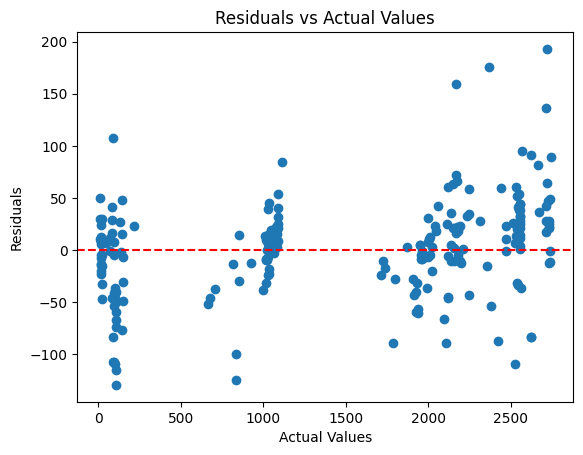

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.show()

In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(y_test - y_pred)
print(f"Durbin-Watson Statistic: {dw_stat}")


Durbin-Watson Statistic: 1.8032814312432277


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant

X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)
X_train_preprocessed = X_train_preprocessed.toarray() if hasattr(X_train_preprocessed, "toarray") else X_train_preprocessed
X_train_const = add_constant(X_train_preprocessed)
residuals = y_train - pipeline.predict(X_train)

bp_test = het_breuschpagan(residuals, X_train_const)
print(f"Breusch-Pagan p-value: {bp_test[1]}")


Breusch-Pagan p-value: 1.1705074951186477e-43


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_preprocessed = preprocessor.fit_transform(X_train)

# Retrieve feature names from the preprocessor
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['series','quarter', 'year'])
all_feature_names = pd.Index(cat_feature_names.tolist())
if hasattr(X_train_preprocessed, "toarray"):
    X_train_preprocessed = X_train_preprocessed.toarray()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = all_feature_names  # Assign the actual feature names
vif_data['VIF'] = [
    variance_inflation_factor(X_train_preprocessed, i)
    for i in range(X_train_preprocessed.shape[1])
]

print(vif_data)

           feature       VIF
0   series_c2_dist  1.827558
1   series_c3_dist  1.811337
2   series_c4_dist  1.847433
3   series_c5_dist  1.858654
4   series_c6_dist  1.865521
5   series_c7_dist  1.822187
6   series_c8_dist  1.853998
7        quarter_2  1.946120
8        quarter_3  1.942928
9        quarter_4  1.965759
10       year_1989  1.203115
11       year_1990  1.212990
12       year_1991  1.243254
13       year_1992  1.215682
14       year_1993  1.215381
15       year_1994  1.206861
16       year_1995  1.228241
17       year_1996  1.209085
18       year_1997  1.214503
19       year_1998  1.254275
20       year_1999  1.228602
21       year_2000  1.194674
22       year_2001  1.222510
23       year_2002  1.267764
24       year_2003  1.193375
25       year_2004  1.214702
26       year_2005  1.251034
27       year_2006  1.226966
28       year_2007  1.204933
29       year_2008  1.194706
30       year_2009  1.205176
31       year_2010  1.233028
32       year_2011  1.220652
33       year_

In [ ]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test
stat, p_value = shapiro(residuals)

# Print results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value > 0.05:
    print("Data appears to be normally distributed (fail to reject H0).")
else:
    print("Data does not appear to be normally distributed (reject H0).")


Shapiro-Wilk Test Statistic: 0.8994235311458143
P-value: 2.447249991478881e-24
Data does not appear to be normally distributed (reject H0).


In [ ]:
print(X_train)

NameError: name 'X_train' is not defined